In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
import warnings
import itertools
warnings.filterwarnings("ignore")

In [2]:
# Importing data
airline_df = pd.read_excel(r"Airlines+Data.xlsx")

In [3]:
airline_df.shape

(96, 2)

In [32]:
airline_df

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


<AxesSubplot: >

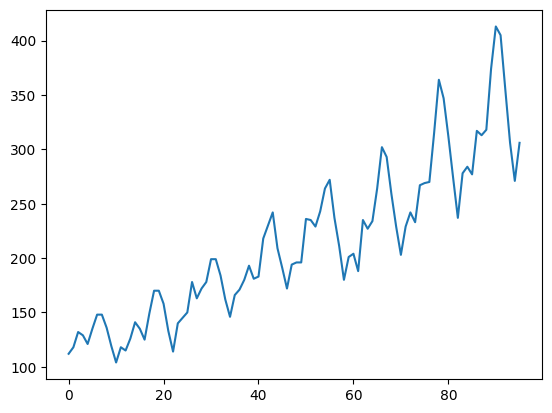

In [5]:
airline_df.Passengers.plot()

<AxesSubplot: >

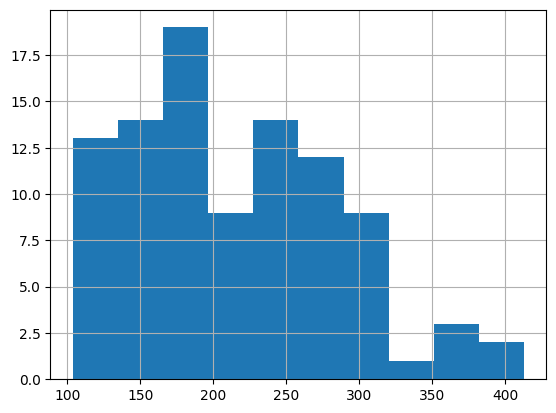

In [6]:
airline_df['Passengers'].hist()

<AxesSubplot: ylabel='Density'>

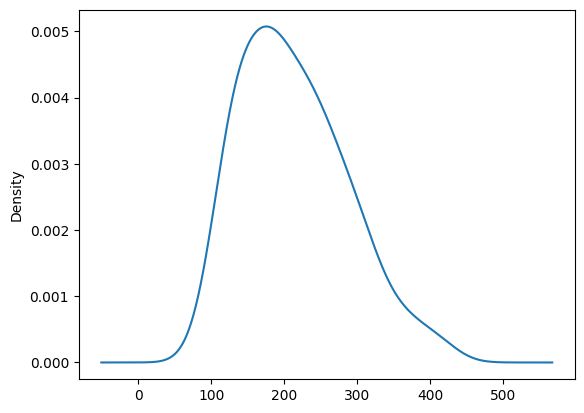

In [7]:
airline_df["Passengers"].plot(kind='kde')

### Moving Average

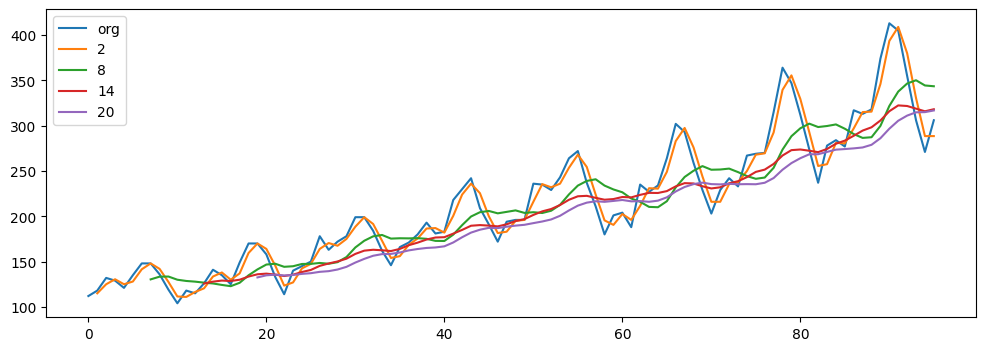

In [8]:
plt.figure(figsize=(12,4))
airline_df.Passengers.plot(label="org")
for i in range(2,24,6):
    airline_df["Passengers"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

### Time series decomposition plot

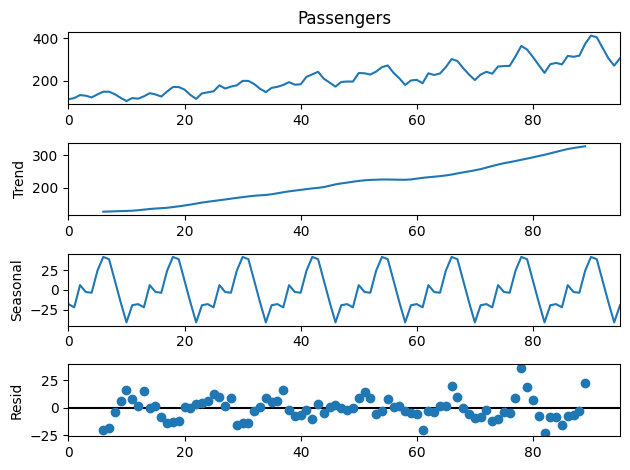

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

decompose_ts_add = seasonal_decompose(airline_df.Passengers,period=12)
decompose_ts_add.plot()
plt.show()

### From the trend and seasonal we can see a clear trend. Hence the data is stationary.

### ACF plots and PACF plots

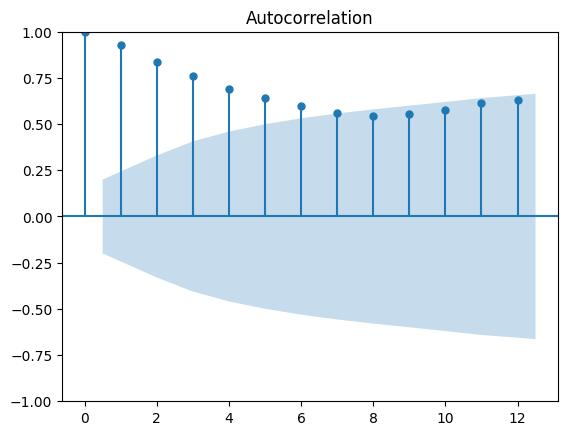

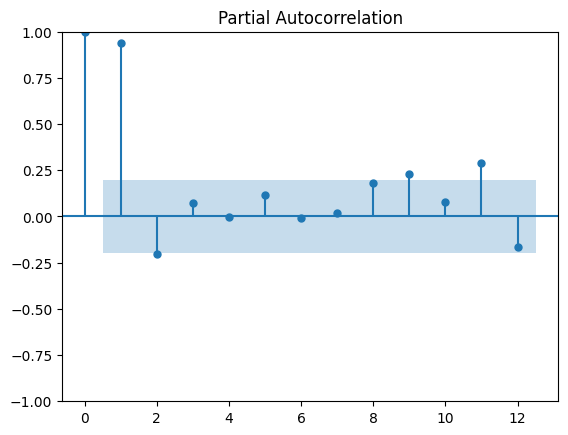

In [10]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(airline_df.Passengers,lags=12)
tsa_plots.plot_pacf(airline_df.Passengers,lags=12)
plt.show()

In [11]:
Train = airline_df.head(35)
Test = airline_df.tail(7)

### Evaluation Metric MAPE

In [12]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

### Simple Exponential Method

In [13]:
ses_model = SimpleExpSmoothing(Train["Passengers"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_ses,Test.Passengers) 

50.56241321436388

### Holt method

In [14]:
# Holt method 
hw_model = Holt(Train["Passengers"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hw,Test.Passengers) 

140.9429202139776

### Holts winter exponential smoothing with additive seasonality and additive trend

In [15]:
hwe_model_add_add = ExponentialSmoothing(Train["Passengers"],seasonal="add",trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_add_add,Test.Passengers) 

20.976868076561605

### Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [16]:
hwe_model_mul_add = ExponentialSmoothing(Train["Passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_mul_add,Test.Passengers)

16.630214645455972

In [19]:
# separate out a validation dataset
split_point = len(airline_df) - 10
dataset, validation = airline_df[0:split_point], airline_df[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset1.csv', header=False)
validation.to_csv('validation1.csv', header=False)

Dataset 86, Validation 10


### Persistence/ Base model

In [20]:
# evaluate a persistence model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
train = read_csv('dataset1.csv', header=None, skiprows=1, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = train.iloc[:, 1]
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

In [21]:
# Assuming 'test' is your pandas DataFrame
test = test.reset_index(drop=True)

In [22]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=230.000, Expected=242.000
>Predicted=242.000, Expected=209.000
>Predicted=209.000, Expected=191.000
>Predicted=191.000, Expected=172.000
>Predicted=172.000, Expected=194.000
>Predicted=194.000, Expected=196.000
>Predicted=196.000, Expected=196.000
>Predicted=196.000, Expected=236.000
>Predicted=236.000, Expected=235.000
>Predicted=235.000, Expected=229.000
>Predicted=229.000, Expected=243.000
>Predicted=243.000, Expected=264.000
>Predicted=264.000, Expected=272.000
>Predicted=272.000, Expected=237.000
>Predicted=237.000, Expected=211.000
>Predicted=211.000, Expected=180.000
>Predicted=180.000, Expected=201.000
>Predicted=201.000, Expected=204.000
>Predicted=204.000, Expected=188.000
>Predicted=188.000, Expected=235.000
>Predicted=235.000, Expected=227.000
>Predicted=227.000, Expected=234.000
>Predicted=234.000, Expected=264.000
>Predicted=264.000, Expected=302.000
>Predicted=302.000, Expected=293.000
>Predicted=293.000, Expected=259.000
>Predicted=259.000, Expected=229.000
>

## ARIMA Model

In [25]:
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

# Load the dataset
data = pd.read_excel('Airlines+Data.xlsx', index_col='Month', parse_dates=True)

# Find the best ARIMA model using auto_arima
model = auto_arima(data['Passengers'], start_p=1, start_q=1, max_p=3, max_q=3, d=1, stepwise=True)

# Print the summary of the best model
print(model.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   96
Model:               SARIMAX(3, 1, 2)   Log Likelihood                -421.170
Date:                Tue, 12 Sep 2023   AIC                            854.341
Time:                        19:57:00   BIC                            869.664
Sample:                    01-01-1995   HQIC                           860.533
                         - 12-01-2002                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1526      0.142      1.071      0.284      -0.127       0.432
ar.L2          0.4062      0.144      2.815      0.005       0.123       0.689
ar.L3         -0.3167      0.121     -2.619      0.0

In [26]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Load the dataset
data = pd.read_excel('Airlines+Data.xlsx', index_col='Month', parse_dates=True)

# Create the ARIMA model
model = ARIMA(data['Passengers'], order=(3, 1, 2))

# Fit the model
model_fit = model.fit()

# Print the summary of the model
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                   96
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -421.170
Date:                Tue, 12 Sep 2023   AIC                            854.341
Time:                        19:58:12   BIC                            869.664
Sample:                    01-01-1995   HQIC                           860.533
                         - 12-01-2002                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1526      0.142      1.071      0.284      -0.127       0.432
ar.L2          0.4062      0.144      2.815      0.005       0.123       0.689
ar.L3         -0.3167      0.121     -2.619      0.0

In [33]:
predictions = model_fit.predict(start=96, end=97)

In [34]:
predictions

2003-01-01    335.594495
2003-02-01    340.202412
Freq: MS, Name: predicted_mean, dtype: float64

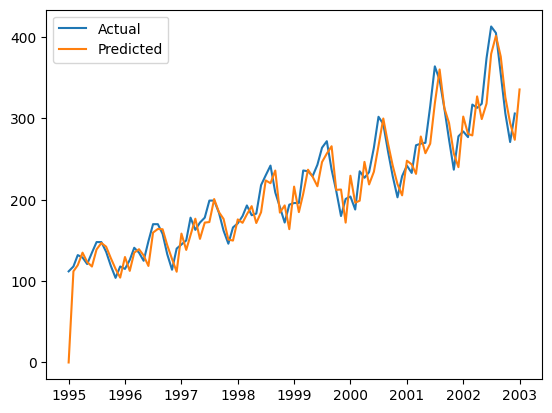

In [36]:
# Make predictions for the future
predictions = model_fit.predict(start=0, end=96)

# Plot the actual values and the predicted values
plt.plot(data['Passengers'], label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

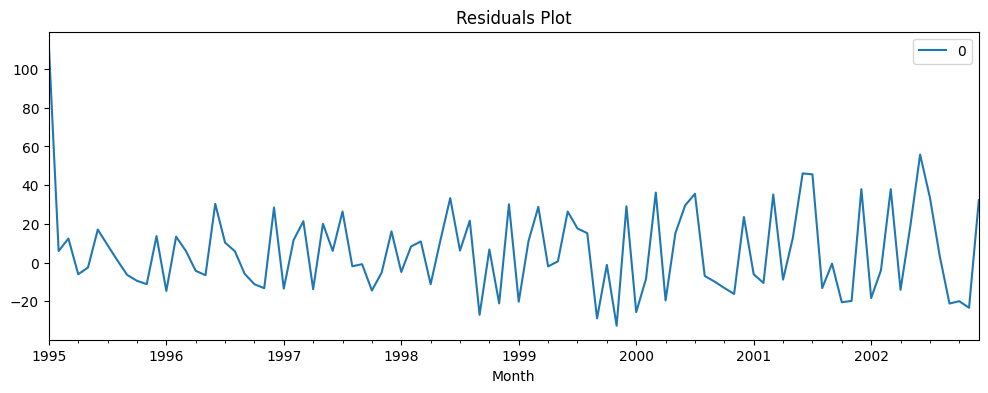

In [27]:
# Plot the residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(figsize=(12, 4))
plt.title('Residuals Plot')
plt.show()